In [1]:
import sys
sys.path.insert(0, "../utils/")
sys.path.insert(0, "../")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [3]:
def image_show(image, figsize=(7, 7)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image, interpolation='nearest')
    plt.tight_layout()
    plt.show()
    

def image_grid_show(image_stack, figsize=(12, 12)):
    fig = plt.figure(figsize=(10, 10))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(4, 4),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                    )
    stack_indices = [i for i in range(image_stack.shape[0])]
    for ax, im_idx in zip(grid, stack_indices):
        ax.imshow(image_stack[im_idx])
    
    plt.show()

# Configuration file parser

In [4]:
from utils.read_config import ConfigYamlParserMPII

In [5]:
config = ConfigYamlParserMPII(path="./../config.yaml")

# MPIIAnnotationHandler

In [6]:
from utils.data import MPIIAnnotationHandler

In [7]:
training_annotation_file = config.TRAINING_ANNOTATION_FILE
validation_annotation_file = config.VALIDATION_ANNOTATION_FILE
image_dir = config.IMAGE_DIR
keypoint_info = config.PARTS

handle = MPIIAnnotationHandler(training_annotation_file, validation_annotation_file, image_dir, keypoint_info)


loading data...
Done (t=3.64s)


In [8]:
sample = handle.get_annotation(idx=0)
sample

('/home/adi/git_clones/torch_shnet/data/MPII/images/015601864.jpg',
 array([[[620., 394.,   1.],
         [616., 269.,   1.],
         [573., 185.,   1.],
         [647., 188.,   0.],
         [661., 221.,   1.],
         [656., 231.,   1.],
         [610., 187.,   0.],
         [647., 176.,   1.],
         [637., 189.,   1.],
         [695., 108.,   1.],
         [606., 217.,   1.],
         [553., 161.,   1.],
         [601., 167.,   1.],
         [692., 185.,   1.],
         [693., 240.,   1.],
         [688., 313.,   1.]]]),
 array([1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([594.        , 302.31569265]),
 3.7763077205121935,
 75.52615441024388)

In [9]:
train_indices, valid_indices = handle.split_data()

In [10]:
train_indices.shape, valid_indices.shape

((22246,), (2958,))

# MPIIDataset

In [11]:
from utils.data import MPIIDataset

In [12]:
train_dataset = MPIIDataset(
    indices=train_indices,
    mpii_annotation_handle=handle,
    input_resolution=256,
    output_resolution=64,
    num_parts=16,
    reference_image_size=200,
    max_rotation_angle=30.,
    image_scale_factor_range=(0.75, 1.75),
    image_color_jitter_probability=0.5,
    image_horizontal_flip_probability=0.5,
    hue_max_delta=0.2,
    saturation_min_delta=0.5,
    brightness_max_delta=0.3,
    contrast_min_delta=0.5
)

valid_dataset = MPIIDataset(
    indices=valid_indices,
    mpii_annotation_handle=handle,
    input_resolution=256,
    output_resolution=64,
    num_parts=16,
    reference_image_size=200,
    max_rotation_angle=30.,
    image_scale_factor_range=(0.75, 1.75),
    image_color_jitter_probability=0.5,
    image_horizontal_flip_probability=0.5,
    hue_max_delta=0.2,
    saturation_min_delta=0.5,
    brightness_max_delta=0.3,
    contrast_min_delta=0.5
)

In [13]:
image, heatmap = train_dataset[0]

image.shape, heatmap.shape

(torch.Size([3, 256, 256]), torch.Size([16, 64, 64]))

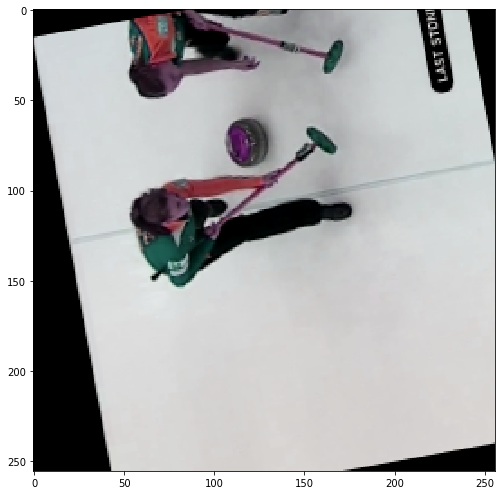

In [14]:
image_show(np.swapaxes(image.numpy(), 0, 2))

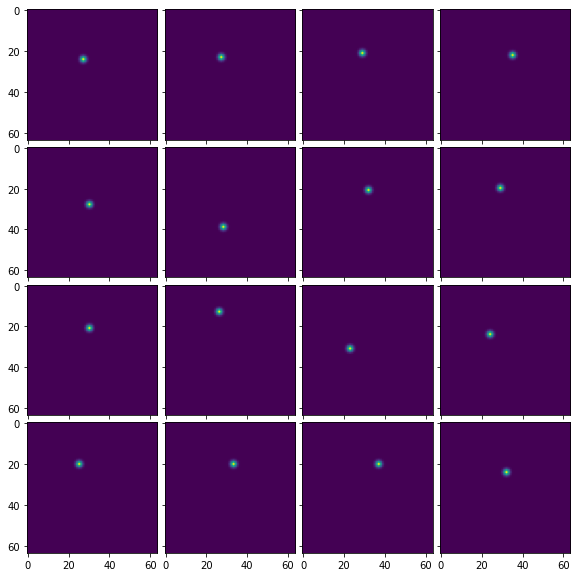

In [15]:
image_grid_show(heatmap.numpy())